Sheet 2.2: ML-estimation
========================

**Author:** Michael Franke



This tutorial is meant to introduce some basics of PyTorch by looking at a simple case study: how to find the best-fitting parameter for the mean of a normal (Gaussian) distribution.
The training data is a set of samples from a &ldquo;true&rdquo; distribution.
The loss function is the negative likelihood that a candidate parameter value for the &ldquo;true mean&rdquo; assigns to the training data.
By using stochastic gradient descent to minimize the loss, we seek the parameter value that maximizes the likelihood of the training data.
This is, therefore, a **maximum likelihood estimation**.



## Packages



We will need to import the \`torch\` package for the main functionality.
We also will use \`seaborn\` for plotting, and \`matplotlib\` for showing the plots.
Finally, we use the \`warnings\` package to suppress all warning messages in the notebook.



In [1]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

## True distribution & training data



The &ldquo;true distribution&rdquo; that generates the data is a normal distribution with a mean (location) stored in the variable \`true_location\`.
(We keep the scale parameter (standard deviation) fixed at a known value of 1.)
The \`torch.distributions\` package contains ready-made probability distributions for sampling.
So, here we define the true distribution, and take \`n_obs\` samples from it, the set of which we call &ldquo;training data&rdquo;.



In [2]:
n_obs = 10000
true_location = 0  # mean of a normal
true_dist = torch.distributions.Normal(loc=true_location, scale=1.0)
train_data = true_dist.sample([n_obs])

The mean of the training data is the so-called **empirical mean**.
The empirical mean need not be identical to the true mean!



In [3]:
empirical_mean = torch.mean(train_data)
print("Empirical mean (mean of training data): %.5f" % empirical_mean.item())

Empirical mean (mean of training data): -0.00150


Here is a density plot of the training data:



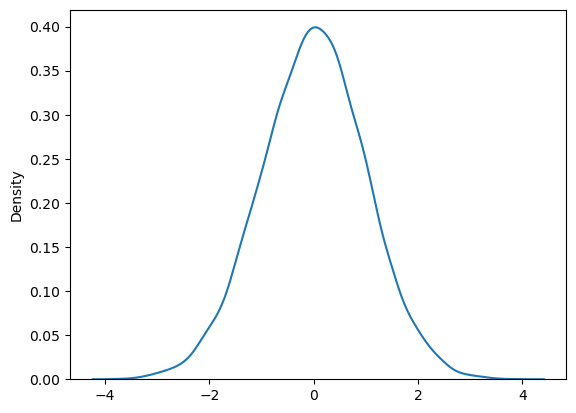

In [4]:
sns.kdeplot(train_data)
plt.show()

## Optimizing a parameter: gradients, optimizers, loss & backprop



We want an estimate of the true mean of the training data.
For that, we define a &ldquo;trainable&rdquo; parameter in PyTorch, which we set to some initial value.
Subsequently, we will update the value of this parameter in a series of training steps, so that it will become &ldquo;better&rdquo; over time.
Being &ldquo;good&rdquo; means having a small &ldquo;loss&rdquo;.
The loss function we are interested in is the likelihood of the training data.

To being with, we define the parameter which is to be trained.
Since we want to &ldquo;massage it&rdquo; through updating, we must tell PyTorch that it should compute the gradient for this parameter (and the ones derived from it).
(NB: For numerical stability we require this parameter to be a 64 bit float. You may try out the exercises below with the default float32 format and compare.)



In [5]:
location = torch.tensor(1.0, requires_grad=True, dtype=torch.float64)
print(location)

tensor(1., dtype=torch.float64, requires_grad=True)


To prepare for training, we first instantiate an **optimizer**, which will do the updating behind the scenes.
Here, we choose the stochastic gradient descent (SGD) optimizer.
To instantiate it, we need to tell it two things:

1.  which parameters to optimize;
2.  how aggressively to update (=> the so-called **learning rate**)



In [6]:
learning_rate = 0.0000001
opt = torch.optim.SGD([location], lr=learning_rate)

Let us now go manually through a single training step.
A training step consists of the following parts:

1.  compute the predictions for the current parameter(s)
    -   what do we predict in the current state?
2.  compute the loss for this prediction
    -   how good is this prediction (for the training data)?
3.  backpropagate the error (using the gradients)
    -   in which direction would we need to change the relevant parameters to make the prediction better?
4.  update step
    -   change the parameters (to a certain degree, the so-called learning rate) in the direction that should make them better
5.  zero the gradient
    -   reset the information about &ldquo;which direction to tune&rdquo; for the next training step



### Part 1: Compute the predictions for current parameter value



The prediction for the current parameter value is a Gaussian with the location parameter set to our current parameter value.
We obtain our &ldquo;current best model&rdquo; by instantiating a distribution like so:



In [7]:
prediction = torch.distributions.Normal(loc=location, scale=1.0)

### Part 2: Computing the loss for the current prediction



How good is our current model?
Goodness can be measured in many ways.
Here we consider the likelihood: how likely is the training data under the current model?



In [8]:
loss = -torch.sum(prediction.log_prob(train_data))
print(loss)

tensor(19274.0312, grad_fn=<NegBackward0>)


Notice that the \`loss\` variable is a single-numbered tensor (containing the information how bad (we want to minimize it) the current parameter value is).
Notice that PyTorch has also added information on how to compute gradients, i.e., it keeps track of way in which values for the variable \`location\` influence the values for the variable \`loss\`.



### Part 3: Backpropagate the error signal



In the next step, we will use the information stored about the functional relation between \`location\` and \`loss\` to infer how the \`location\` parameter would need to be changed to make \`loss\` higher or lower.
This is the so-called backpropagation step.

Concretely, at the outset, the gradient information for \`location\` is &ldquo;NONE&rdquo;.



In [9]:
print(f"Value (initial)                = {location.item()}")
print(f"Gradient information (initial) = {location.grad}")

Value (initial)                = 1.0
Gradient information (initial) = None


We must actively tell the system to backpropagate the information in the gradients, like so:



In [10]:
loss.backward()
print(f"Value (after backprop)                = {location.item()}")
print(f"Gradient information (after backprop) = {location.grad}")

Value (after backprop)                = 1.0
Gradient information (after backprop) = 10015.0458984375


### Part 4: Update the parameter values



Next, we use the information in the gradient to actually update the trainable parameter values.
This is what the optimizer does.
It knows which parameters to update (we told it), so the relevant update function is one associated with the optimizer itself.



In [11]:
opt.step()
print(f"Value (after step)                = {location.item()}")
print(f"Gradient information (after step) = {location.grad}")

Value (after step)                = 0.9989984954101563
Gradient information (after step) = 10015.0458984375


### Part 5: Reset the gradient information



If we want to repeat the updating process, we need to erase information about gradients for the last prediction.
This is because otherwise information would just accumulate in the gradients.
This zero-ing of the gradients is again something we do holistically (for all parameters to train) through the optimizer object:



In [12]:
opt.zero_grad()
print(f"Value (after zero-ing)                = {location.item()}")
print(f"Gradient information (after zero-ing) = {location.grad}")

Value (after zero-ing)                = 0.9989984954101563
Gradient information (after zero-ing) = None


## Training loop



After having gone through our cycle of parameter updating step-by-step, let&rsquo;s iterate this in a training loop consisting of \`n_training_steps\`.



In [13]:
n_training_steps = 10000
print("\n%5s %24s %15s %15s" % ("step", "loss", "estimate", "diff. target"))
for i in range(n_training_steps):
    prediction = torch.distributions.Normal(loc=location, scale=1.0)
    loss = -torch.sum(prediction.log_prob(train_data))
    loss.backward()
    if (i + 1) % 500 == 0:
        print(
            "%5d %24.3f %15.5f %15.5f"
            % (
                i + 1,
                loss.item(),
                location.item(),
                abs(location.item() - empirical_mean),
            )
        )
    opt.step()
    opt.zero_grad()


 step                     loss        estimate    diff. target
  500                16102.988         0.60579         0.60729
 1000                14937.011         0.36674         0.36825
 1500                14508.284         0.22179         0.22330
 2000                14350.645         0.13390         0.13540
 2500                14292.682         0.08060         0.08211
 3000                14271.368         0.04828         0.04979
 3500                14263.533         0.02869         0.03019
 4000                14260.650         0.01680         0.01831
 4500                14259.591         0.00960         0.01110
 5000                14259.201         0.00523         0.00673
 5500                14259.059         0.00258         0.00408
 6000                14259.006         0.00097         0.00248
 6500                14258.986        -0.00000         0.00150
 7000                14258.979        -0.00059         0.00091
 7500                14258.977        -0.00095        

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 2.2.1: Explore the optimization process</span></strong>
>
> This exercise is intended to make you play around with the parameters of the training procedure, namely \`learning_rate\` and \`n_training_steps\`, and to develop a feeling for what they do. There is not necessarily a single &ldquo;true&rdquo; solution. Report the values that you found to work best for each of the following cases:
>
> 1. Change the initial value of the parameter \`location\` to -5000.
>
> 2. Revert to initial conditions. Change the true mean (parameter \`true_location\`) to 5000.
>
> 3. Revert to initial conditions. Use only 100 samples for the training set (using variable \`n_obs\`).

